In [2]:
import networkx as nx

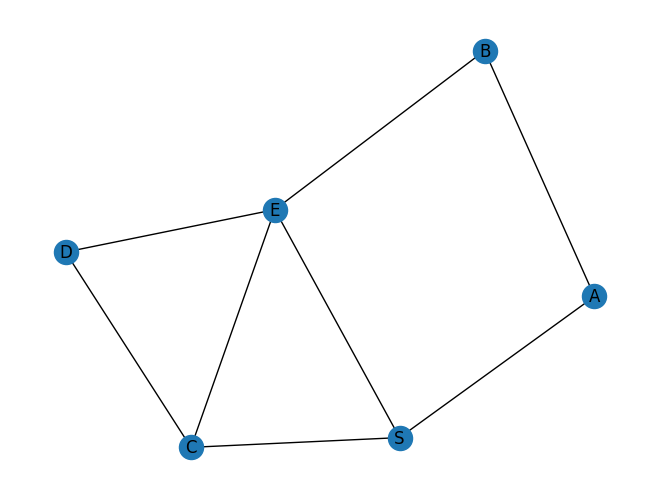

In [6]:
graph = nx.MultiGraph()
graph.add_edge('S', 'A', length=2, traveled=True)
graph.add_edge('A', 'B', length=2, traveled=True)
graph.add_edge('S', 'E', length=1, traveled=True)
graph.add_edge('B', 'E', length=2, traveled=False)
graph.add_edge('S', 'C', length=2, traveled=False)
graph.add_edge('C', 'D', length=3, traveled=False)
graph.add_edge('D', 'E', length=1, traveled=False)
graph.add_edge('C', 'E', length=2.5, traveled=False)
nx.set_node_attributes(graph, {
    "S": {"x": 0, "y": 0},
    "A": {"x": 2, "y": 0},
    "B": {"x": 0, "y": -1},
    "C": {"x": 0, "y": 2},
    "D": {"x": -2, "y": 2},
    "E": {"x": -1, "y": 0}
})
# graph = nx.to_undirected(graph)
nx.draw(graph, with_labels=True)

In [10]:
# graph.nodes["S"]
nx.multi_source_dijkstra_path_length(graph, ['C', "A"], weight='length')

{'C': 0, 'A': 0, 'S': 2, 'B': 2, 'E': 2.5, 'D': 3}

### Next up we load up the AStar exploration graph functionality.

In [24]:
from astar_algo.MaxHeap import MaxHeap
from astar_algo.ExplorationGraph import *
from astar_algo.MaxScoreFrontier import MaxScoreFrontier
from astar_algo.ExplorationSearch import optimal_path_search, optimal_path_search_internal

In [25]:
settings = ExplorationGraphSettings(
    target_length=5,
    overlength_penalty=1.5,
    outregion_penalty=0.5,
    start_nodes=["S"],
    goal_nodes=["E"]
)

In [26]:
import math

# Overwrite the distance function for testing (Euclidean distance instead of Haversine)
ex_graph = ExplorationGraph(graph, settings, crs="WGS84")
ex_graph.distance = lambda node1, node2: math.sqrt((node1["x"]-node2["x"]) ** 2 + (node1["y"]-node2["y"]) ** 2)

In [27]:
# Test Exploration Graph by expanding a dummy starter path
arc = ExplorationArc(None, "S", 0, None)
continuing = ex_graph.continuing_paths(ExplorationPath([arc], 0, 0, 0))
test_path = continuing[2]
def print_list(l):
    print("\n".join(str(item) for item in l))
print("Test path arcs: ")
print_list(test_path.arcs)
print()
print("Test path score so far: ", test_path.score)
print("Best-case test path score (f-score): ", ex_graph.best_case_score(test_path))

Test path arcs: 
ExplorationArc(tail=None, head='S', key=0, attributes=None)
ExplorationArc(tail='S', head='C', key=0, attributes={'length': 2, 'traveled': False})

Test path score so far:  2.0
Best-case test path score (f-score):  5.0


In [28]:
frontier = MaxScoreFrontier(ex_graph)
search = optimal_path_search_internal(ex_graph, frontier)
optimal_path = next(search)
print("Optimal path score:", optimal_path.score)
print()
print("Optimal path arcs: ")
print_list(optimal_path.arcs)
# That's the right path! A very good sign.
next_path = next(search)
print(next_path.score)
print_list(next_path.arcs)
# This also looks good.

Optimal path score: 4.5

Optimal path arcs: 
ExplorationArc(tail=None, head='S', key=0, attributes=None)
ExplorationArc(tail='S', head='C', key=0, attributes={'length': 2, 'traveled': False})
ExplorationArc(tail='C', head='E', key=0, attributes={'length': 2.5, 'traveled': False})


In [30]:
# Poke around in the search object to see what's going on
p = search.gi_frame.f_locals["found_paths"]
print("Max heap of unused found paths:")
print_list(p)
print("\nFirst unused found path: ")
print_list(p.container[0][2].arcs)
print("\nFrontier Heap: ")
print_list(frontier.heap)
print("\nFirst heap path: ")
print_list(frontier.heap.container[0][2].arcs)
# The search state looks like I would expect, no unexpected extra paths or anything.


Max heap of unused found paths:
(-0.0, 1, <astar_algo.ExplorationGraph.ExplorationPath object at 0x0000016BE54FEED0>)

First unused found path: 
ExplorationArc(tail=None, head='S', key=0, attributes=None)
ExplorationArc(tail='S', head='E', key=0, attributes={'length': 1, 'traveled': True})

Frontier Heap: 
(-0.3786796564403573, 6, <astar_algo.ExplorationGraph.ExplorationPath object at 0x0000016BE559F690>)

First heap path: 
ExplorationArc(tail=None, head='S', key=0, attributes=None)
ExplorationArc(tail='S', head='A', key=0, attributes={'length': 2, 'traveled': True})
ExplorationArc(tail='A', head='B', key=0, attributes={'length': 2, 'traveled': True})


In [31]:
# Print out remaining paths
for path in search:
    print(path.score)
    print_list(path.arcs)
    print()

0.0
ExplorationArc(tail=None, head='S', key=0, attributes=None)
ExplorationArc(tail='S', head='E', key=0, attributes={'length': 1, 'traveled': True})

-0.5
ExplorationArc(tail=None, head='S', key=0, attributes=None)
ExplorationArc(tail='S', head='A', key=0, attributes={'length': 2, 'traveled': True})
ExplorationArc(tail='A', head='B', key=0, attributes={'length': 2, 'traveled': True})
ExplorationArc(tail='B', head='E', key=0, attributes={'length': 2, 'traveled': False})



### Next up, the ACO algo